In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import datetime
import numpy as np
from scipy import stats
from scipy.stats import ttest_ind
plt.style.use('fivethirtyeight')
sns.set()
plt.rcParams['figure.figsize']= (12,12)

In [10]:
GRAPH = 'Results/Graphs'
TABLE = 'Results/Tables'

<h3> Importing 3 Excel Sheets and merging into a single Dataframe</h3>

In [3]:
df = pd.read_excel('BDjobs_ITjob_posting.xlsx',sheet_name=1,keep_default_na=False) #Reading All Sheets
df1 = pd.read_excel('BDjobs_ITjob_posting.xlsx',sheet_name=2,keep_default_na=False)
df2 = pd.read_excel('BDjobs_ITjob_posting.xlsx',sheet_name=3,keep_default_na=False)
df = pd.concat([df,df1,df2]) # Merging All Sheets in a df.
df.shape

(15637, 21)

In [44]:
# df.loc[df.TotalVacancy.str.match(r'201[0-9]{1}-[0-9]{2}-[0-9]{2}.*'),'TotalVacancy'] = 0 # Clean Date
df.TotalVacancy = df.TotalVacancy.astype(str) #Must Convert to str before using isdigit
df = df[df.TotalVacancy.str.isdigit()] # Clean not int
df.TotalVacancy = df.TotalVacancy.astype(int) #Convert to int

In [2]:
# df.to_csv('Main_Dataset.csv',index=False)
df = pd.read_csv('Main_Dataset.csv',keep_default_na=False) #Loading saved df and Keeping N/A as it is.

In [3]:
df.shape

(11963, 21)

<h3> Extracting Date Time Information from Data </h3>

In [4]:
df['Time'] = pd.to_datetime(df['PublishDate']).dt.year #Determining Which Yr the job is posted.
# df.Month = df.Month.apply(lambda x : x.strftime('%Y-%m'))
# df['Month'] = df['Month'].dt.to_period('Q') # Dividing into 4 Quarter

<h3>Choose Desired Sector</h3>

In [5]:
industries = df.IndustryName.value_counts().index[2:10].values  # Choosing Industries to Analysis
# df = df[df['IndustryName'].isin(cat)]
industries

array(['Garments/ Textile', 'Telecommunication', 'Education',
       'NGO/Development', 'Manufacturing (Heavy Industry)',
       'Electronics/ Consumer Durables',
       'Media (Satellite/ Print/ Online)/ Advertising/ Event Mgt.',
       'Bank/ Non-Bank Fin. Institution'], dtype=object)

<h3> Correct/Drop Invalid TotalVacancy Value </h3>

In [113]:
# df.TotalVacancy.replace({'Multiple':1,'3 (Three)':3,'01 (One)':1,
#                               '10 (Chittagong, Sylhet, Comilla, Mymensing & Khuln':10,
#                               '5+':5,'15 person clipping expert man urgent':15, '15  (Fresher-10, Others-5)':15,
#                               '02 (Female will get advantage)':2, 'Based on requirement.':1,
#                              },inplace =True)
# df = df[df.TotalVacancy.apply( lambda x:type(x) != datetime.datetime)]
# # df = df[df.TotalVacancy.apply( lambda x:type(x) != str)]

In [8]:
df.loc[df.JobTitle.str.contains('Software',case=False),'JobTitleRefined'] = 'Software Engineer' #Cleaning SWE
df.loc[df.JobTitle.str.contains('Web',case=False),'JobTitleRefined'] = 'Web Developer' #Cleaning WD

<h1> April 9 : Hypothesis Testing </h1>

In [6]:
def chi_squared_test(df,field,column,prob=0.95):
    contigency_table = pd.crosstab(df[field],df[column])
    stat,p,dof,expected = stats.chi2_contingency(contigency_table)
    critical = stats.chi2.ppf(prob,dof)
    contigency_table.plot.bar(stacked=False)
    results = []
    results.append(field,stat,critical)
    results = pd.DataFrame(results,columns=[field,'Value','Critical'])
    return results

<h1> Analysing Software Engineer </h1>

In [28]:
def t_test(df,job,field,exceptions=[],save=False):
    results = pd.DataFrame(columns = ['Job','Industry','Time','Statistic','p-value','significant'])
    combos = [(2016,2017),(2017,2018),(2016,2018)]
    soft_df = df[df.JobTitleRefined == job]
    for industry in industries:
        for yr1,yr2 in combos:
            temp = soft_df[soft_df.IndustryName == industry]
            cat1 = temp[temp['Time']==yr1]
            cat2 = temp[temp['Time']==yr2]
            if industry in exceptions: #Media doesn't have significant amount of data
                continue
            stat, p = ttest_ind(cat1[field], cat2[field],equal_var=False)
            results = results.append({'Job':job,'Industry':industry,
                                      'Time':str(yr1) + "-" + str(yr2),'Statistic':stat,
                                      'p-value':p,'significant': p < 0.1},ignore_index=True)
    
    temp = results.drop(['Job'],axis=1).pivot(index='Industry',columns='Time')
    temp = temp.T.reindex(['2016-2017','2017-2018','2016-2018'],level=1).T #Reording Results yrs
    print(temp)
    if save:
        #Casting Object to float64 for formatting
        temp[[('Statistic', '2016-2017'),('Statistic', '2017-2018'),('Statistic', '2016-2018'),
             ('p-value', '2016-2017')  ,('p-value', '2017-2018')  ,('p-value', '2016-2018') ] ]\
        =temp[[('Statistic', '2016-2017'),('Statistic', '2017-2018'),('Statistic', '2016-2018'),
             ('p-value', '2016-2017')  ,('p-value', '2017-2018')  ,('p-value', '2016-2018') ] ].astype(float) 
        temp.drop([('Statistic', '2016-2017'),('Statistic', '2017-2018'),('Statistic', '2016-2018')],
                  axis=1,inplace=True)
        temp.to_csv(f'{TABLE}/{job}_{field}_ttest.csv',index=True,float_format='%.3f')
    return temp

In [29]:
temp = t_test(df,job='Web Developer',field = 'MaleGender',save=True,)
#       exceptions = ['Media (Satellite/ Print/ Online)/ Advertising/ Event Mgt.'])

temp

                                                   Statistic            \
Time                                               2016-2017 2017-2018   
Industry                                                                 
Bank/ Non-Bank Fin. Institution                          NaN       NaN   
Education                                                NaN  2.529822   
Electronics/ Consumer Durables                           NaN  1.000000   
Garments/ Textile                                        NaN  3.162278   
Manufacturing (Heavy Industry)                           NaN  1.732051   
Media (Satellite/ Print/ Online)/ Advertising/ ...       NaN  2.390457   
NGO/Development                                          NaN  2.000000   
Telecommunication                                        NaN       NaN   

                                                               p-value  \
Time                                               2016-2018 2016-2017   
Industry                             

p-value            \
Time                                               2016-2017 2017-2018   
Industry                                                                 
Bank/ Non-Bank Fin. Institution                          NaN       NaN   
Education                                                NaN  0.035265   
Electronics/ Consumer Durables                           NaN  0.500000   
Garments/ Textile                                        NaN  0.025031   
Manufacturing (Heavy Industry)                           NaN  0.181690   
Media (Satellite/ Print/ Online)/ Advertising/ ...       NaN  0.037929   
NGO/Development                                          NaN  0.183503   
Telecommunication                                        NaN       NaN   

                                                             significant  \
Time                                               2016-2018   2016-2017   
Industry                                                                   
Bank/ Non-Bank Fin. Institution                          NaN       False   
Education                                           0.035265       False   
Electronics/ Consumer Durables                      0.500000       False   
Garments/ Textile                                   0.025031       False   
Manufacturing (Heavy Industry)                      0.181690       False   
Media (Satellite/ Print/ Online)/ Advertising/ ...  0.037929       False   
NGO/Development                                     0.183503       False   
Telecommunication                                        NaN       False   

                                                                        
Time                                               2017-2018 2016-2018  
Industry                                                                
Bank/ Non-Bank Fin. Institution                        False     False  
Education                                               True      True  
Electronics/ Consumer Durables                         False     False  
Garments/ Textile                                       True      True  
Manufacturing (Heavy Industry)                         False     False  
Media (Satellite/ Print/ Online)/ Advertising/ ...      True      True  
NGO/Development                                        False     False  
Telecommunication                                      False     False

In [24]:
def ttest_plot(df,job,field,save=False):
    soft_df = df[df.JobTitleRefined == job]
    plot_df = soft_df[soft_df.IndustryName.isin(industries)]
    plot_df = plot_df.groupby(['IndustryName','Time'])[field].sum().reset_index()
    sns.barplot(x='IndustryName',y=field,hue='Time',data=plot_df)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(f'{GRAPH}/{job}_{field}_ttest.png',dpi=350)

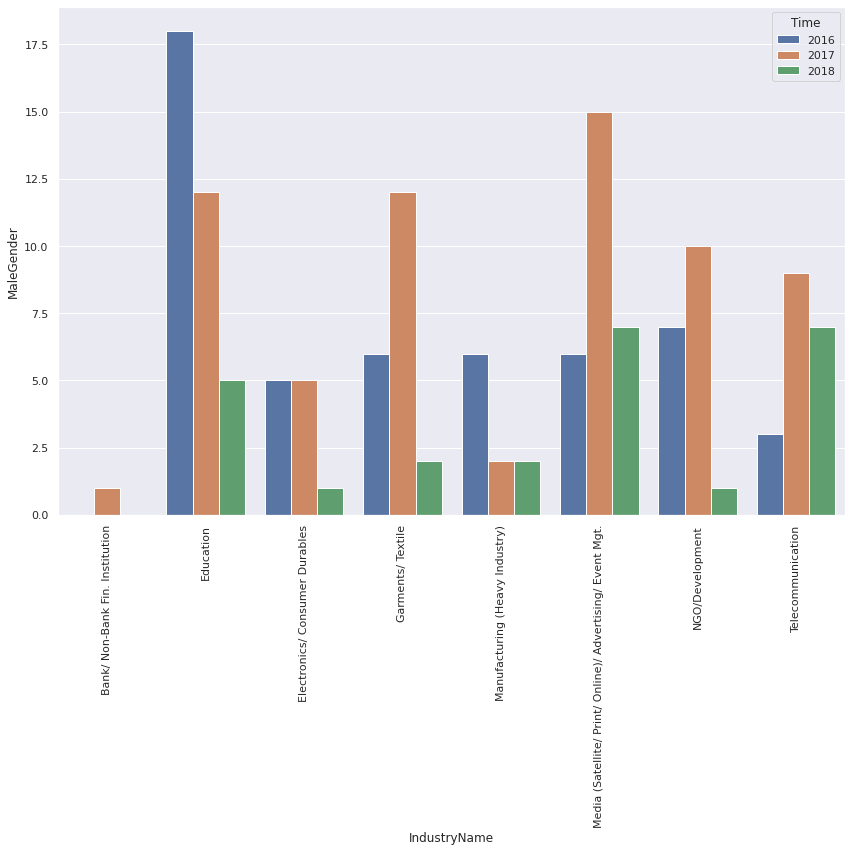

In [25]:
ttest_plot(df,'Web Developer','MaleGender',save=True)

In [31]:
df[(df['JobTitleRefined'] == 'Web Developer') & (df['Time'] == 2018)].MaleGender.value_counts()

1    257
0     76
Name: MaleGender, dtype: int64